In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# Correlation between Citation Rate and Author h-index

In [2]:
# Read in Author metadata, which where acquired from OpenAlex beforehand

with open('../../../data/author_metadata_publications.json', 'r', encoding='utf-8') as json_file:
    author_works_dict = json.load(json_file)

In [3]:
# Define observable time span for calculating the h-index backwards
years = list(range(2012, 2023))  

# Dictionary for saving the h-index of the authors over the years for every author
author_yearly_citations = {}

for author, publications in author_works_dict.items():
    author_yearly_citations[author] = {year: [] for year in years}

    for publication in publications:
        total_citations = publication[0]

        # Calculate the citations of the works back to the starting point (2012)
        for citation in publication[1]:
            total_citations -= citation["cited_by_count"]

        # Dictionary for quick lookup of citation counts by year
        citations_by_year = {entry['year']: entry['cited_by_count'] for entry in publication[1]}

        # List to store the cumulative citations for each year
        cumulative_citations = []

        # Assigns the corresponding citations for every year, starting in 2012
        for year in years:
            if year >= publication[3]:  # Only calculate backwards to the point of publication release or to 2012
                if year in citations_by_year:
                    total_citations += citations_by_year[year]
                cumulative_citations.append(total_citations)

                # Store the citations under the author and the corresponding year
                author_yearly_citations[author][year].append(total_citations)

# Dictionary to store the calculated h-indices for every author
author_h_index_by_year = {}

# Calculating the h-index for every year for every author starting in 2012
for author, yearly_citations in author_yearly_citations.items():
    author_h_index_by_year[author] = {}
    for year in years:
        citations = yearly_citations[year]
        citations.sort(reverse=True)
        h_index = sum(1 for i, c in enumerate(citations) if c >= i + 1)
        author_h_index_by_year[author][year] = h_index


# Boxplot to compare authors participant in trec, lncs and ceur by h-index


In [4]:
def load_json(filepath):
    """
    Loads a JSON file and returns the parsed data.

    Args:
        filepath (str): Path to the JSON file.

    Returns:
        dict: Parsed JSON data as a dictionary.
    """
    with open(filepath, 'r', encoding="utf-8") as f:
        return json.load(f)

def combine_json_files(json_paths):
    """
    Combines multiple JSON files into a single dictionary. If an item ID 
    exists in more than one file, it merges the data.

    Args:
        json_paths (list of str): List of file paths to JSON files.

    Returns:
        dict: Combined JSON data as a single dictionary.
    """
    combined_data = {}
    for path in json_paths:
        data = load_json(path)
        for item_id, item_data in data.items():
            if item_id not in combined_data:
                combined_data[item_id] = item_data
            else:
                # Merging if item_id already exists
                combined_data[item_id].update(item_data)
    return combined_data
    
def boxplot_author_hindex(filepath, figure_title, filename):
    """
    Generates a boxplot of the H-Index distribution by year for authors 
    in the given OpenAlex metadata.

    Args:
        filepath (str or list of str): Path(s) to the JSON file(s) containing OpenAlex metadata.
        figure_title (str): Title of the boxplot figure.
        filename (str): Name of the file to save the boxplot as a PNG.

    Returns:
        None
    """
    # Load and combine JSON files if needed
    if type(filepath) == list:
        OpenAlex_metadata = combine_json_files(filepath)

    if type(filepath) == str:
        OpenAlex_metadata = load_json(filepath)

    # Initialize a dictionary to store H-Index values by year
    h_index_by_year = {year: [] for year in range(2012, 2023)}

    # Iterate through the OpenAlex metadata
    for doc in OpenAlex_metadata.values():
        # Consider only publications between 2012 and 2022
        publication_year = int(doc['publication_year'])  
        if publication_year < 2012 or publication_year > 2022:
            continue  
            
        # Process each authorship and accumulate H-Index values by year
        for authorship in doc['authorships']:
            author_id = authorship['author']['id']
            if author_id in author_h_index_by_year and publication_year in author_h_index_by_year[author_id]:
                h_index = author_h_index_by_year[author_id][publication_year]
                h_index_by_year[publication_year].append(h_index)


    years = list(range(2012, 2023))
    data_to_plot = [h_index_by_year[year] for year in years]
    
    # Create the boxplot
    plt.figure(figsize=(10, 6))
    plt.boxplot(data_to_plot, labels=years)
    plt.xlabel('Year')
    plt.ylabel('H-Index')
    plt.title(figure_title)
    plt.savefig(f'../../../images/{filename}.png', dpi=300)  # Save the figure as a PNG file with 300 dpi
    
    plt.show()

C:\Users\Andreas\AppData\Local\Temp\ipykernel_1168\2518593173.py:79: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=years)


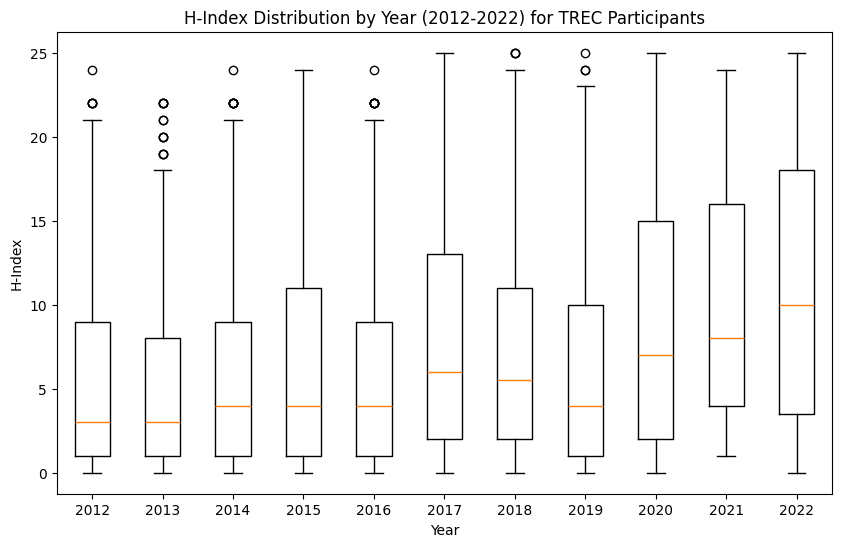

In [5]:
boxplot_author_hindex("../../../data/OpenAlex_TREC.json", "H-Index Distribution by Year (2012-2022) for TREC Participants", "boxplot_hindex_trec")

C:\Users\Andreas\AppData\Local\Temp\ipykernel_1168\2518593173.py:79: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=years)


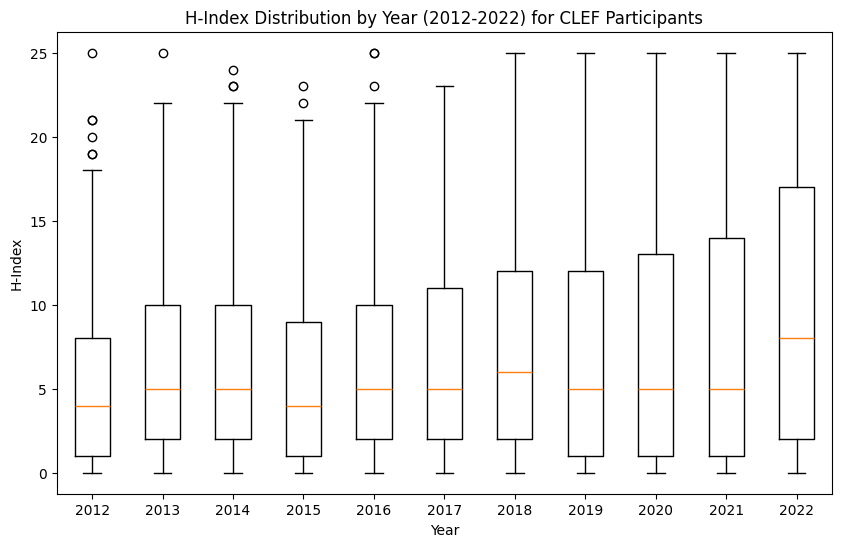

In [6]:
boxplot_author_hindex(["../../../data/OpenAlex_CEUR.json", "../../../data/OpenAlex_LNCS.json"], "H-Index Distribution by Year (2012-2022) for CLEF Participants", "boxplot_hindex_clef")

# Correlation analysis CURRENT h-index to CURRENT citation rate

In [7]:
def calculate_h_index_list(metadata_filepaths, author_path):
    """
    Loads publication and author metadata, then calculates the average H-index 
    and citation count for each publication.

    Args:
        metadata_filepaths (list of str): List of file paths to publication JSON files.
        author_path (str): File path to the JSON file containing author metadata.
        
    Returns:
        dict: A dictionary with keys corresponding to publication file names 
              and values as lists of lists, where each sublist contains:
              [publication_id, citation_count, average_h_index].
    """
    # Load the author metadata
    author_data = load_json(author_path)

    # Dictionary to hold the results for each publication dataset
    results = {}
    
    # Iterate over each publication file path
    for path in metadata_filepaths:
        # Load the publication metadata
        OpenAlex_metadata = load_json(path)
        result_list = []
        
        # Iterate through each publication in the data
        for publication_id, publication_info in OpenAlex_metadata.items():
            publication_year = publication_info["publication_year"]
            h_index_avg = 0
            counter = 0
            
            # Iterate through each authorship for the publication
            for authorship in publication_info["authorships"]:
                author_id = authorship["author"]["id"]
                if author_id in author_data:
                    h_index_avg += author_data[author_id]["summary_stats"]["h_index"]
                    counter += 1
            
            # Avoid division by zero in case there are no valid authors
            if counter > 0:
                h_index_avg = h_index_avg / counter
            
            # Append the publication ID, citation count, and average H-index to the result list
            result_list.append([publication_id, publication_info["cited_by_count"], h_index_avg])
        
        # Store the result list using the file name (without path) as the key
        results[path.split('/')[-1]] = result_list
    
    return results

# Paths to the JSON files
publication_paths = [
    "../../../data/OpenAlex_TREC.json",
    "../../../data/OpenAlex_CEUR.json",
    "../../../data/OpenAlex_LNCS.json"
]
author_json_path = "../../../data/author_metadata.json"

# Calculate the H-index lists for each dataset
results = calculate_h_index_list(publication_paths, author_json_path)

In [8]:
df1 = pd.DataFrame(results["OpenAlex_TREC.json"], columns=["ID", "Citations", "hindex"])
df2 = pd.DataFrame(results["OpenAlex_CEUR.json"], columns=["ID", "Citations", "hindex"])
df3 = pd.DataFrame(results["OpenAlex_LNCS.json"], columns=["ID", "Citations", "hindex"])

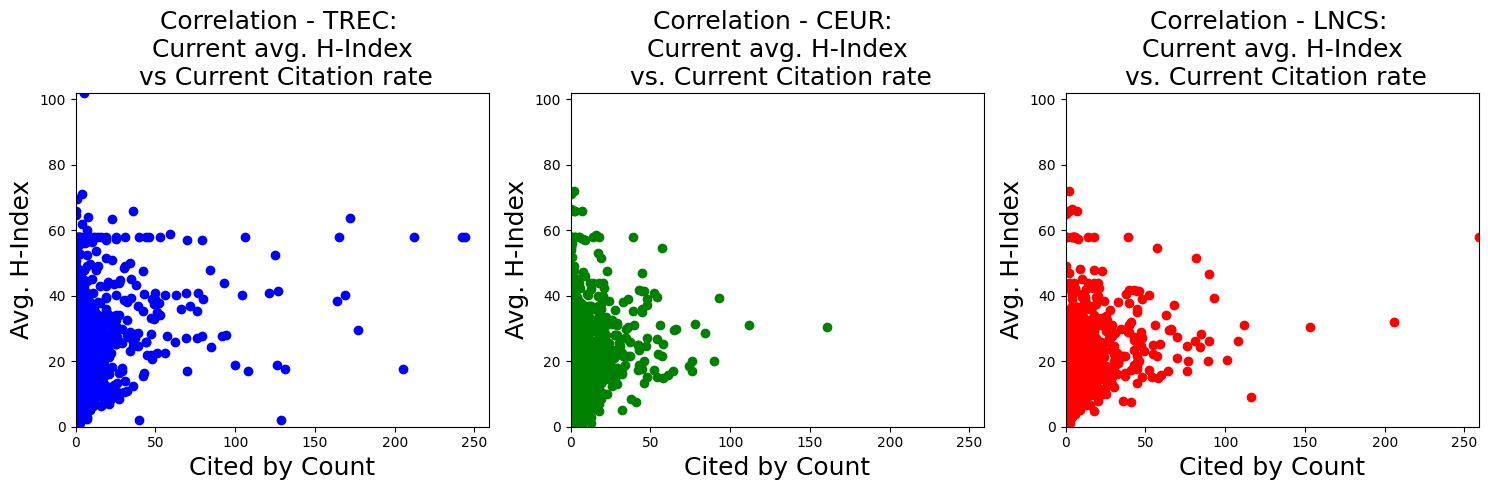

In [11]:
# Determine the minimum and maximum values for axis limits across all DataFrames
min_citations = min(df1['Citations'].min(), df2['Citations'].min(), df3['Citations'].min())
max_citations = max(df1['Citations'].max(), df2['Citations'].max(), df3['Citations'].max())

min_hindex = min(df1['hindex'].min(), df2['hindex'].min(), df3['hindex'].min())
max_hindex = max(df1['hindex'].max(), df2['hindex'].max(), df3['hindex'].max())

# Create the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(df1['Citations'], df1['hindex'], color='blue')
axs[0].set_title('Correlation - TREC: \n Current avg. H-Index \n vs Current Citation rate', fontsize=18)
axs[0].set_xlabel('Cited by Count', fontsize=18)
axs[0].set_ylabel('Avg. H-Index', fontsize=18)
# Set consistent x and y axis limits for all plots
axs[0].set_xlim(min_citations, max_citations)
axs[0].set_ylim(min_hindex, max_hindex)

axs[1].scatter(df2['Citations'], df2['hindex'], color='green')
axs[1].set_title('Correlation - CEUR: \n Current avg. H-Index \n vs. Current Citation rate', fontsize=18)
axs[1].set_xlabel('Cited by Count', fontsize=18)
axs[1].set_ylabel('Avg. H-Index', fontsize=18)
axs[1].set_xlim(min_citations, max_citations)
axs[1].set_ylim(min_hindex, max_hindex)

axs[2].scatter(df3['Citations'], df3['hindex'], color='red')
axs[2].set_title('Correlation - LNCS: \n Current avg. H-Index \n vs. Current Citation rate', fontsize=18)
axs[2].set_xlabel('Cited by Count', fontsize=18)
axs[2].set_ylabel('Avg. H-Index', fontsize=18)
axs[2].set_xlim(min_citations, max_citations)
axs[2].set_ylim(min_hindex, max_hindex)

plt.tight_layout()
plt.savefig('../../../images/correlation_CURRENT_hindex_CURRENT_citations.png', dpi=300)  
plt.show()

In [82]:
from scipy.stats import pearsonr
correlation, p_value = pearsonr(df1["Citations"], df1["hindex"])
print(f'Pearson-Korrelation: {correlation}')
print(f'P-Wert: {p_value}')

Pearson-Korrelation: 0.3190251931732464
P-Wert: 9.324944600380611e-42


In [83]:
from scipy.stats import pearsonr
correlation, p_value = pearsonr(df2["Citations"], df2["hindex"])
print(f'Pearson-Korrelation: {correlation}')
print(f'P-Wert: {p_value}')

Pearson-Korrelation: 0.25320808808593737
P-Wert: 4.726131862389793e-43


In [84]:
from scipy.stats import pearsonr
correlation, p_value = pearsonr(df3["Citations"], df3["hindex"])
print(f'Pearson-Korrelation: {correlation}')
print(f'P-Wert: {p_value}')

Pearson-Korrelation: 0.271747087222415
P-Wert: 1.058122628092297e-22


# Correlation analysis h-index from publication year to CURRENT citation rate

In [12]:
def calculate_h_index_list(metadata_filepaths, author_path):
    """
    Loads publication and author metadata, then calculates the average H-index 
    and citation count for each publication.

    Args:
        metadata_filepaths (list of str): List of file paths to publication JSON files.
        author_path (str): File path to the JSON file containing author metadata.
        
    Returns:
        dict: A dictionary with keys corresponding to publication file names 
              and values as lists of lists, where each sublist contains:
              [publication_id, citation_count, average_h_index].
    """
    # Load the author metadata
    author_data = load_json(author_path)

    # Dictionary to hold the results for each publication dataset
    results = {}
    
    # Iterate over each publication file path
    for path in metadata_filepaths:
        # Load the publication metadata
        OpenAlex_metadata = load_json(path)
        result_list = []
        
        # Iterate through each publication in the data
        for publication_id, publication_info in OpenAlex_metadata.items():
            publication_year = publication_info["publication_year"]
            if publication_year >= 2012 and publication_year <= 2022:
                h_index_avg = 0
                counter = 0
                
                # Iterate through each authorship for the publication
                for authorship in publication_info["authorships"]:
                    author_id = authorship["author"]["id"]
                    if author_id in author_data:
                        h_index_avg += author_h_index_by_year[author_id][publication_year]
                        counter += 1
                
                # Avoid division by zero in case there are no valid authors
                if counter > 0:
                    h_index_avg = h_index_avg / counter
                
                # Append the publication ID, citation count, and average H-index to the result list
                result_list.append([publication_id, publication_info["cited_by_count"], h_index_avg])
            
            # Store the result list using the file name (without path) as the key
            results[path.split('/')[-1]] = result_list
        
    return results

# Paths to the JSON files
publication_paths = [
    "../../../data/OpenAlex_TREC.json",
    "../../../data/OpenAlex_CEUR.json",
    "../../../data/OpenAlex_LNCS.json"
]
author_json_path = "../../../data/author_metadata.json"

# Calculate the H-index lists for each dataset
results = calculate_h_index_list(publication_paths, author_json_path)

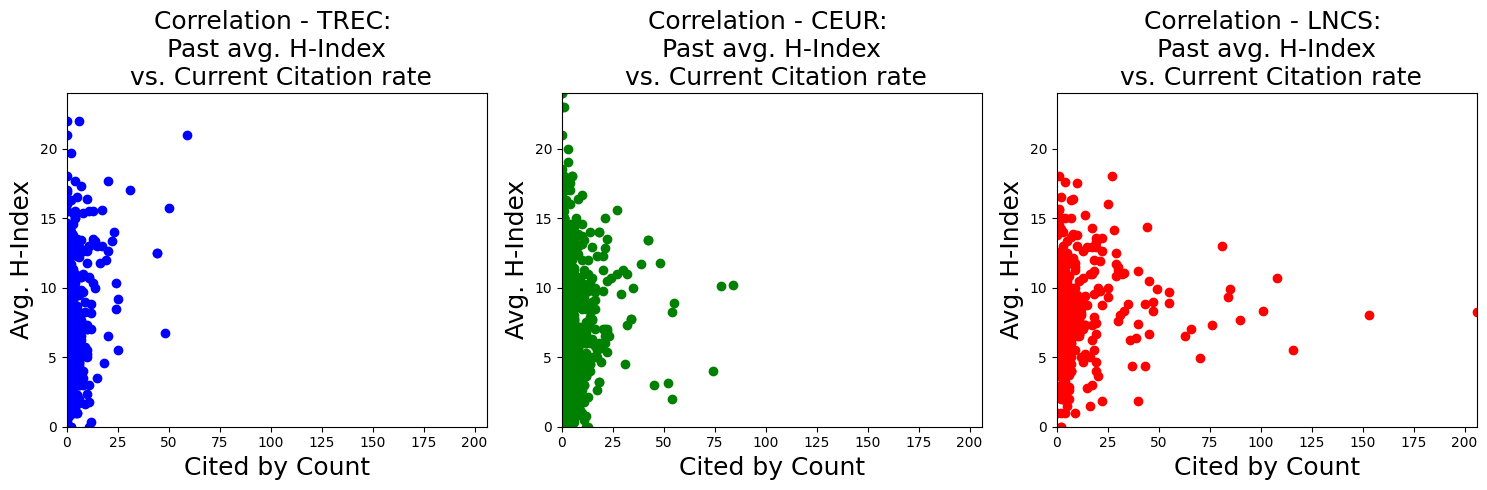

In [14]:
import pandas as pd
df1 = pd.DataFrame(results["OpenAlex_TREC.json"], columns=["ID", "Citations", "hindex"])
df2 = pd.DataFrame(results["OpenAlex_CEUR.json"], columns=["ID", "Citations", "hindex"])
df3 = pd.DataFrame(results["OpenAlex_LNCS.json"], columns=["ID", "Citations", "hindex"])

# Determine the minimum and maximum values for axis limits across all DataFrames
min_citations = min(df1['Citations'].min(), df2['Citations'].min(), df3['Citations'].min())
max_citations = max(df1['Citations'].max(), df2['Citations'].max(), df3['Citations'].max())

min_hindex = min(df1['hindex'].min(), df2['hindex'].min(), df3['hindex'].min())
max_hindex = max(df1['hindex'].max(), df2['hindex'].max(), df3['hindex'].max())

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(df1['Citations'], df1['hindex'], color='blue')
axs[0].set_title('Correlation - TREC: \n Past avg. H-Index \n vs. Current Citation rate', fontsize=18)
axs[0].set_xlabel('Cited by Count', fontsize=18)
axs[0].set_ylabel('Avg. H-Index', fontsize=18)
# Set consistent x and y axis limits for all plots
axs[0].set_xlim(min_citations, max_citations)
axs[0].set_ylim(min_hindex, max_hindex)

axs[1].scatter(df2['Citations'], df2['hindex'], color='green')
axs[1].set_title('Correlation - CEUR: \n Past avg. H-Index \n vs. Current Citation rate', fontsize=18)
axs[1].set_xlabel('Cited by Count', fontsize=18)
axs[1].set_ylabel('Avg. H-Index', fontsize=18)
axs[1].set_xlim(min_citations, max_citations)
axs[1].set_ylim(min_hindex, max_hindex)

axs[2].scatter(df3['Citations'], df3['hindex'], color='red')
axs[2].set_title('Correlation - LNCS: \n Past avg. H-Index \n vs. Current Citation rate', fontsize=18)
axs[2].set_xlabel('Cited by Count', fontsize=18)
axs[2].set_ylabel('Avg. H-Index', fontsize=18)
axs[2].set_xlim(min_citations, max_citations)
axs[2].set_ylim(min_hindex, max_hindex)

plt.tight_layout()
plt.savefig('../../../images/correlation_past_hindex_CURRENT_citations.png', dpi=300)  # Save the figure as a PNG file with 300 dpi
plt.show()

In [87]:
from scipy.stats import pearsonr
correlation, p_value = pearsonr(df1["Citations"], df1["hindex"])
print(f'Pearson-Korrelation: {correlation}')
print(f'P-Wert: {p_value}')

correlation, p_value = pearsonr(df2["Citations"], df2["hindex"])
print(f'Pearson-Korrelation: {correlation}')
print(f'P-Wert: {p_value}')

correlation, p_value = pearsonr(df3["Citations"], df3["hindex"])
print(f'Pearson-Korrelation: {correlation}')
print(f'P-Wert: {p_value}')

Pearson-Korrelation: 0.2736855579476385
P-Wert: 4.808592996219958e-13
Pearson-Korrelation: 0.09625693544815508
P-Wert: 6.221356684329113e-05
Pearson-Korrelation: 0.04938922140377501
P-Wert: 0.36751260623727794


# Signiciance test of the author performances

In [88]:
trec_data = load_json("../../../data/OpenAlex_TREC.json")
ceur_data = load_json("../../../data/OpenAlex_CEUR.json")
lncs_data = load_json("../../../data/OpenAlex_LNCS.json")

In [89]:
author_data = load_json("../../../data/author_metadata.json")


In [90]:
trec_authors_h_index = []
id_list = []
for i, j in trec_data.items():
    for k in j["authorships"]:
        if k["author"]["id"] not in id_list:   
            trec_authors_h_index.append(author_data[k["author"]["id"]]["summary_stats"]["h_index"])
            id_list.append(k["author"]["id"])

clef_authors_h_index= []
id_list = []
for i, j in ceur_data.items():
    for k in j["authorships"]:
        if k["author"]["id"] not in id_list:   
            clef_authors_h_index.append(author_data[k["author"]["id"]]["summary_stats"]["h_index"])
            id_list.append(k["author"]["id"])

for i, j in lncs_data.items():
    for k in j["authorships"]:
        if k["author"]["id"] not in id_list:   
            clef_authors_h_index.append(author_data[k["author"]["id"]]["summary_stats"]["h_index"])
            id_list.append(k["author"]["id"])

In [91]:
import scipy.stats as stats

# Testing for normal-distributed data in order to decide for applying a t-test or a Mann-Whitey U test
stat_trec, p_trec = stats.shapiro(trec_authors_h_index)
stat_clef, p_clef = stats.shapiro(clef_authors_h_index)

print(f"Shapiro-Wilk-Test for TREC: Statistic={stat_trec}, P-value={p_trec}")
print(f"Shapiro-Wilk-Test for CLEF: Statistic={stat_clef}, P-value={p_clef}")

Shapiro-Wilk-Test for TREC: Statistic=0.7852343829815365, P-value=4.866532727893114e-55
Shapiro-Wilk-Test for CLEF: Statistic=0.7563397729229926, P-value=1.900946149052591e-66


D:\Studium\Masterarbeit\PythonProject\MasterThesisEnv\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5257.
  res = hypotest_fun_out(*samples, **kwds)


In [92]:
# Applying Mann Whitney U due to not normal-ditsributed data
u_stat, p_value = stats.mannwhitneyu(trec_authors_h_index, clef_authors_h_index, alternative='two-sided')

print(f"Mann-Whitney-U-Test Statistic: {u_stat}")
print(f"P-value: {p_value}")

Mann-Whitney-U-Test Statistic: 9935376.5
P-value: 4.078030072424528e-21


In [93]:
import numpy as np

# Calculate median to assume the direction
median_trec = np.median(trec_authors_h_index)
median_clef = np.median(clef_authors_h_index)

print(f"Median of TREC H-indices: {median_trec}")
print(f"Median of CLEF H-indices: {median_clef}")

Median of TREC H-indices: 11.0
Median of CLEF H-indices: 8.0


In [94]:
# Apply the same for the authors contributing before and after 2010

trec_authors_h_index = []
id_list = []
for i, j in trec_data.items():
    if j["publication_year"] < 2010:
        for k in j["authorships"]:
            if k["author"]["id"] not in id_list:   
                trec_authors_h_index.append(author_data[k["author"]["id"]]["summary_stats"]["h_index"])
                id_list.append(k["author"]["id"])

clef_authors_h_index= []
id_list = []
for i, j in ceur_data.items():
    if j["publication_year"] < 2010:
        for k in j["authorships"]:
            if k["author"]["id"] not in id_list:   
                clef_authors_h_index.append(author_data[k["author"]["id"]]["summary_stats"]["h_index"])
                id_list.append(k["author"]["id"])
            
for i, j in lncs_data.items():
    if j["publication_year"] < 2010:
        for k in j["authorships"]:
            if k["author"]["id"] not in id_list:   
                clef_authors_h_index.append(author_data[k["author"]["id"]]["summary_stats"]["h_index"])
                id_list.append(k["author"]["id"])

In [95]:
import scipy.stats as stats

stat_trec, p_trec = stats.shapiro(trec_authors_h_index)
stat_clef, p_clef = stats.shapiro(clef_authors_h_index)

print(f"Shapiro-Wilk-Test für TREC: Statistic={stat_trec}, P-value={p_trec}")
print(f"Shapiro-Wilk-Test für CLEF: Statistic={stat_clef}, P-value={p_clef}")

Shapiro-Wilk-Test für TREC: Statistic=0.8164815042167501, P-value=6.768537982049972e-41
Shapiro-Wilk-Test für CLEF: Statistic=0.8201133223916732, P-value=1.361540073996145e-34


In [96]:
# Mann-Whitney-U-Test durchführen
u_stat, p_value = stats.mannwhitneyu(trec_authors_h_index, clef_authors_h_index, alternative='two-sided')

print(f"Mann-Whitney-U-Test Statistic: {u_stat}")
print(f"P-value: {p_value}")

Mann-Whitney-U-Test Statistic: 1117952.5
P-value: 0.006408583295219932


In [97]:
import numpy as np

median_trec = np.median(trec_authors_h_index)
median_clef = np.median(clef_authors_h_index)

print(f"Median of TREC H-indices: {median_trec}")
print(f"Median of CLEF H-indices: {median_clef}")

Median of TREC H-indices: 12.0
Median of CLEF H-indices: 11.0


In [98]:
# Apply the same for the authors contributing before and after 2010

trec_authors_h_index = []
id_list = []
for i, j in trec_data.items():
    if j["publication_year"] > 2010:
        for k in j["authorships"]:
            if k["author"]["id"] not in id_list:   
                trec_authors_h_index.append(author_data[k["author"]["id"]]["summary_stats"]["h_index"])
                id_list.append(k["author"]["id"])

clef_authors_h_index= []
id_list = []
for i, j in ceur_data.items():
    if j["publication_year"] > 2010:
        for k in j["authorships"]:
            if k["author"]["id"] not in id_list:   
                clef_authors_h_index.append(author_data[k["author"]["id"]]["summary_stats"]["h_index"])
                id_list.append(k["author"]["id"])
            
for i, j in lncs_data.items():
    if j["publication_year"] > 2010:
        for k in j["authorships"]:
            if k["author"]["id"] not in id_list:   
                clef_authors_h_index.append(author_data[k["author"]["id"]]["summary_stats"]["h_index"])
                id_list.append(k["author"]["id"])

In [99]:
import scipy.stats as stats

stat_trec, p_trec = stats.shapiro(trec_authors_h_index)
stat_clef, p_clef = stats.shapiro(clef_authors_h_index)

print(f"Shapiro-Wilk-Test for TREC: Statistic={stat_trec}, P-value={p_trec}")
print(f"Shapiro-Wilk-Test for CLEF: Statistic={stat_clef}, P-value={p_clef}")

Shapiro-Wilk-Test for TREC: Statistic=0.783347393724763, P-value=3.1494283463210146e-43
Shapiro-Wilk-Test for CLEF: Statistic=0.7520619643855304, P-value=1.3568775474487481e-61


In [100]:
# Mann-Whitney-U-Test durchführen
u_stat, p_value = stats.mannwhitneyu(trec_authors_h_index, clef_authors_h_index, alternative='two-sided')

print(f"Mann-Whitney-U-Test Statistic: {u_stat}")
print(f"P-value: {p_value}")

Mann-Whitney-U-Test Statistic: 4031905.5
P-value: 9.208732549469222e-14


In [101]:
import numpy as np

median_trec = np.median(trec_authors_h_index)
median_clef = np.median(clef_authors_h_index)

print(f"Median of TREC H-indices: {median_trec}")
print(f"Median of CLEF H-indices: {median_clef}")

Median of TREC H-indices: 10.0
Median of CLEF H-indices: 7.0


# Average Author Performance within and outside the proceedings 

In [102]:
author_works_dict

{'https://openalex.org/A5009450184': [[2,
   [{'year': 2014, 'cited_by_count': 1}],
   'https://openalex.org/W2184501159',
   2014],
  [1, [], 'https://openalex.org/W2394732248', 2014]],
 'https://openalex.org/A5000922278': [[70,
   [{'year': 2024, 'cited_by_count': 3},
    {'year': 2023, 'cited_by_count': 17},
    {'year': 2022, 'cited_by_count': 17},
    {'year': 2021, 'cited_by_count': 23},
    {'year': 2020, 'cited_by_count': 7},
    {'year': 2013, 'cited_by_count': 1}],
   'https://openalex.org/W2945391245',
   2019],
  [37,
   [{'year': 2023, 'cited_by_count': 4},
    {'year': 2022, 'cited_by_count': 6},
    {'year': 2021, 'cited_by_count': 8},
    {'year': 2020, 'cited_by_count': 7},
    {'year': 2019, 'cited_by_count': 7},
    {'year': 2018, 'cited_by_count': 3}],
   'https://openalex.org/W2784473403',
   2018],
  [14,
   [{'year': 2024, 'cited_by_count': 6},
    {'year': 2023, 'cited_by_count': 7},
    {'year': 2022, 'cited_by_count': 1}],
   'https://openalex.org/W4283392776'

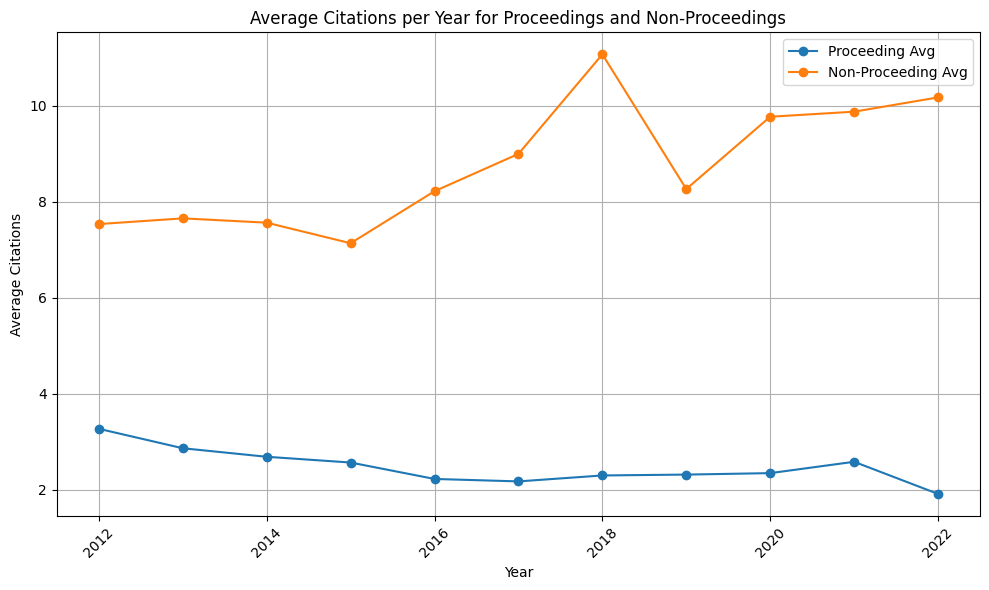

In [103]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict

def analyze_citations_and_plot(metadata_file,filename):
    """
    Analyzes citation data from a JSON file and plots the average citations per year for proceedings and non-proceedings.
    
    Args:
        metadata_file (str): Path to the JSON file containing publication metadata.
        
    Returns:
        None
    """
    # Load data from JSON files
    with open(metadata_file, 'r', encoding='utf-8') as f:
        OpenAlex_metadata = json.load(f)
        
    # Extract IDs from TREC data
    ids_of_proceedings = [pub_info["id"] for pub_info in OpenAlex_metadata.values()]
    
    # Initialize dictionaries for yearly citation and publication counts
    yearly_citations = defaultdict(lambda: {'proceeding': 0, 'non_proceeding': 0})
    yearly_publications = defaultdict(lambda: {'proceeding': 0, 'non_proceeding': 0})

    # Process each author's papers
    for author_id, papers in author_works_dict.items():
        temp_yearly_citations = defaultdict(lambda: {'proceeding': 0, 'non_proceeding': 0})
        temp_yearly_publications = defaultdict(lambda: {'proceeding': 0, 'non_proceeding': 0})

        has_proceeding_and_non_proceeding = set()

        for paper in papers:
            paper_id = paper[2]
            is_proceeding = paper_id in ids_of_proceedings

            for citation in paper[1]:
                year = citation['year']
                cited_by_count = citation['cited_by_count']

                if is_proceeding:
                    temp_yearly_citations[year]['proceeding'] += cited_by_count
                    temp_yearly_publications[year]['proceeding'] += 1
                else:
                    temp_yearly_citations[year]['non_proceeding'] += cited_by_count
                    temp_yearly_publications[year]['non_proceeding'] += 1

                if temp_yearly_citations[year]['proceeding'] > 0 and temp_yearly_citations[year]['non_proceeding'] > 0:
                    has_proceeding_and_non_proceeding.add(year)

        # Aggregate the results
        for year in has_proceeding_and_non_proceeding:
            yearly_citations[year]['proceeding'] += temp_yearly_citations[year]['proceeding']
            yearly_citations[year]['non_proceeding'] += temp_yearly_citations[year]['non_proceeding']
            yearly_publications[year]['proceeding'] += temp_yearly_publications[year]['proceeding']
            yearly_publications[year]['non_proceeding'] += temp_yearly_publications[year]['non_proceeding']

    # Calculate average citations
    average_citations = {}
    for year, counts in yearly_citations.items():
        proceeding_avg = counts['proceeding'] / yearly_publications[year]['proceeding'] if yearly_publications[year]['proceeding'] > 0 else 0
        non_proceeding_avg = counts['non_proceeding'] / yearly_publications[year]['non_proceeding'] if yearly_publications[year]['non_proceeding'] > 0 else 0
        average_citations[year] = {
            'proceeding_avg': proceeding_avg,
            'non_proceeding_avg': non_proceeding_avg
        }

    
    # Plot the results
    years = sorted(average_citations.keys())[:-2]
    proceeding_avg = [average_citations[year]['proceeding_avg'] for year in years]
    non_proceeding_avg = [average_citations[year]['non_proceeding_avg'] for year in years]

    plt.figure(figsize=(10, 6))
    plt.plot(years, proceeding_avg, label='Proceeding Avg', marker='o')
    plt.plot(years, non_proceeding_avg, label='Non-Proceeding Avg', marker='o')

    plt.xlabel('Year')
    plt.ylabel('Average Citations')
    plt.title('Average Citations per Year for Proceedings and Non-Proceedings')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'../../../images/{filename}.png', dpi=300)
    plt.show()

metadata_file = '../../../data/OpenAlex_TREC.json'
analyze_citations_and_plot(metadata_file,"average_citation_TREC_non_TREC")

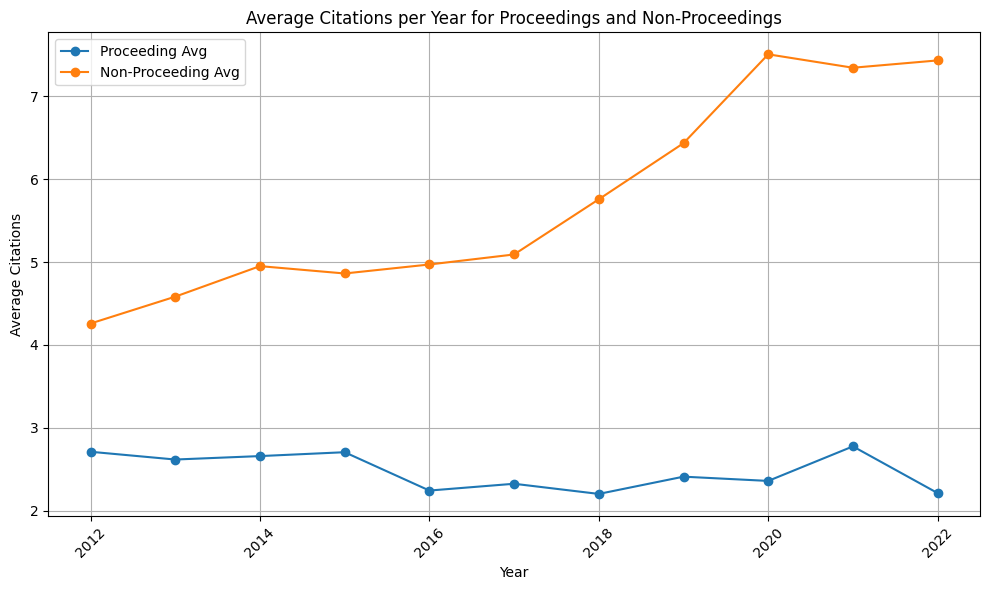

In [104]:
metadata_file = "../../../data/OpenAlex_CEUR.json"
analyze_citations_and_plot(metadata_file,"average_citation_CEUR_non_CEUR")

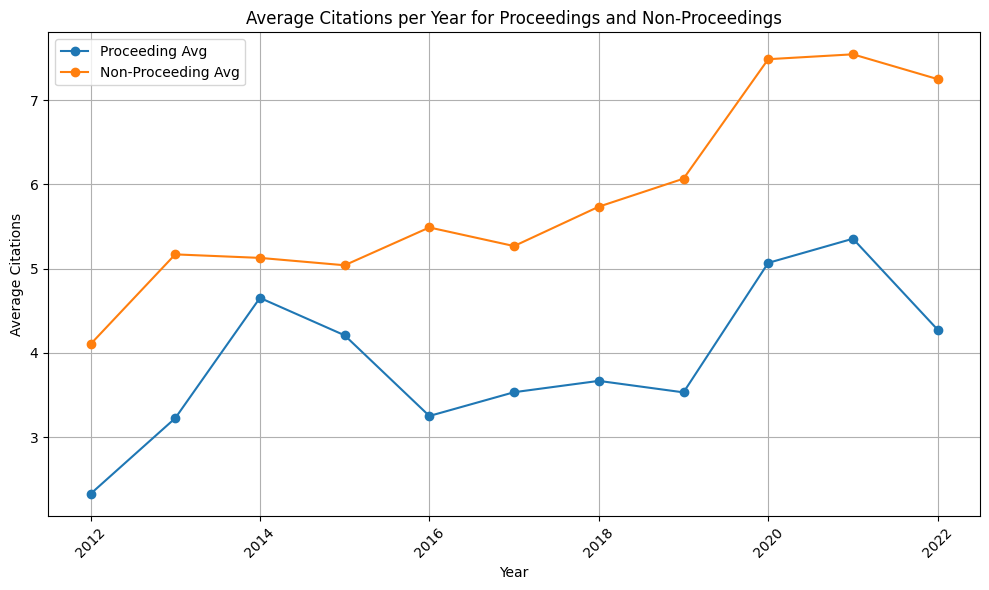

In [105]:
metadata_file = "../../../data/OpenAlex_LNCS.json"
analyze_citations_and_plot(metadata_file,"average_citation_LNCS_non_LNCS")